В данном ноутбуке будет представлен один из вариантов построения доверительных интервалов для precision_recall и specificity_recall кривых с помощью метода Bootstrap

Данные и модель могут быть абсолютно любыми, однако в нашем случае будет использоваться предобработанный датасет о крушении Титаника + Логистическая регрессия. В данном примере это не играет особого значения, обратить внимание стоит именно на реализацию вышеупомянутого метода

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

## считываем данные и получаем предсказания (вероятности)

df = pd.read_csv('titanic_example_df.csv')
X = df.drop('Survived', axis = 1).values
y_true = df['Survived'].values
classifier = LogisticRegression().fit(X, y_true)
y_prob = classifier.predict_proba(X)[:, 1]

Вместо ф-ции precision_recall_curve из библиотеки sklearn напишем её аналог, поскольку для нас важно сохранять все значения соответствующих метрик для каждой отсечки (кривая из библитеки сохраняет лишь уникальные значения).

In [19]:
def custom_precision_recall_curve(y_true, y_prob):

    # Sorting predictions (desc)
    idx = np.argsort(y_prob)[::-1]
    y_prob = y_prob[idx]
    y_true = y_true[idx]

    precision = np.zeros(len(y_true))
    recall = np.zeros(len(y_true))

    tp = 0
    fp = 0
    fn = np.sum(y_true == 1)

    for i in range(len(y_true)):
         if y_true[i] == 1:
            tp += 1
            fn -= 1
         else:
            fp += 1
         recall[i] = tp / (tp + fn)
         precision[i] = tp / (tp + fp)

    return np.array(precision), np.array(recall)

In [20]:
# Фиксируем размер доверительного интервала, ключ для генерации индексов + количество Bootstrap выборок

conf = 0.95
alpha = 1 - conf
rng_seed = 42
rng = np.random.RandomState(rng_seed)
n_bootstrap = 10000

In [21]:
precisions = []
recalls = []

In [22]:
for i in tqdm(range(n_bootstrap)):
    idx = rng.randint(0, len(y_true), len(y_prob)) 
    y_true_b, y_prob_b = y_true[idx], y_prob[idx]  # генерация рандомной выборки на основе исходной
    step_precision, step_recall = custom_precision_recall_curve(y_true_b, y_prob_b) # вычисление точности и полноты для каждой выборки
    precisions.append(step_precision)
    recalls.append(step_recall)

  0%|          | 0/10000 [00:00<?, ?it/s]

Итоговое значение метрики есть ничто иное, как её усредненное значение для отсечки на Bootstrap выборках. На них же вычисляем границы доверительных интервалов.

In [23]:
precisions = np.array(precisions)
precisions = precisions[~np.isnan(precisions).any(axis = 1)]
precision = np.mean(precisions, axis = 0)

recalls = np.array(recalls)
recalls = recalls[~np.isnan(recalls).any(axis = 1)]
recall = np.mean(recalls, axis = 0)

precision_lcb = np.quantile(precisions, (alpha / 2), axis = 0)
precision_ucb = np.quantile(precisions, (1 - (alpha / 2)), axis = 0)

recall_lcb = np.quantile(recalls, (alpha / 2), axis = 0)
recall_ucb = np.quantile(recalls, (1 - (alpha / 2)), axis = 0)

recall, precision = np.clip(recall, 0, 1), np.clip(precision, 0, 1)
precision_lcb, precision_ucb = np.clip(precision_lcb, 0, 1), np.clip(precision_ucb, 0, 1)
recall_lcb, recall_ucb = np.clip(recall_lcb, 0, 1), np.clip(recall_ucb, 0, 1)

In [24]:
len(precision), len(recall)

(891, 891)

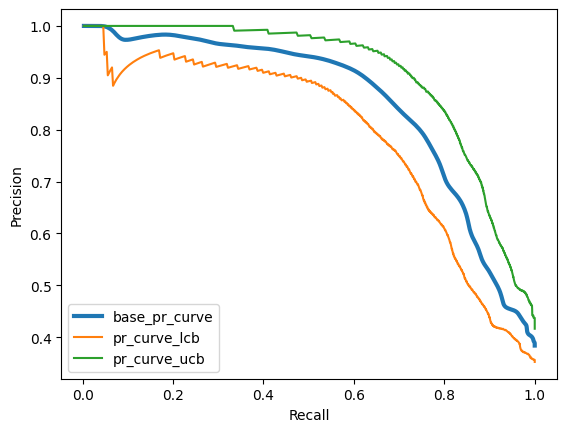

In [25]:
# Визуализация полученных результатов

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.plot(recall, precision, linewidth = 3, label = 'base_pr_curve')
plt.plot(recall_lcb, precision_lcb, label = 'pr_curve_lcb')
plt.plot(recall_ucb, precision_ucb, label = 'pr_curve_ucb')

plt.legend();

Аналогиным образом поступаем в случае specificity_recall кривой

In [26]:
def custom_specificity_recall_curve(y_true, y_prob):

    idx = np.argsort(y_prob)[::-1]
    y_prob = y_prob[idx]
    y_true = y_true[idx]

    specificity = np.zeros(len(y_true))
    recall = np.zeros(len(y_true))

    tp = 0
    fp = 0
    fn = np.sum(y_true == 1)
    tn = np.sum(y_true == 0)

    for i in range(len(y_true)):
         if y_true[i] == 1:
            tp += 1
            fn -= 1
         else:
            fp += 1
         recall[i] = tp / (tp + fn)
         specificity[i] = tn / (tn + fp)

    return np.array(specificity), np.array(recall)

In [27]:
conf = 0.95
alpha = 1 - conf
rng_seed = 42
rng = np.random.RandomState(rng_seed)
n_bootstrap = 10000

In [28]:
specificities = []
recalls = []

for i in tqdm(range(n_bootstrap)):
    idx = rng.randint(0, len(y_true), len(y_prob))
    y_true_b, y_prob_b = y_true[idx], y_prob[idx]
    step_specificity, step_recall = custom_specificity_recall_curve(y_true_b, y_prob_b)
    specificities.append(step_specificity)
    recalls.append(step_recall)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [29]:
specificities = np.array(specificities)
specificities = specificities[~np.isnan(specificities).any(axis = 1)]
specificity = np.mean(specificities, axis = 0)

recalls = np.array(recalls)
recalls = recalls[~np.isnan(recalls).any(axis = 1)]
recall = np.mean(recalls, axis = 0)

specificity_lcb = np.quantile(specificities, (alpha / 2), axis = 0)
specificity_ucb = np.quantile(specificities, (1 - (alpha / 2)), axis = 0)

recall_lcb = np.quantile(recalls, (alpha / 2), axis = 0)
recall_ucb = np.quantile(recalls, (1 - (alpha / 2)), axis = 0)

recall, specificity = np.clip(recall, 0, 1), np.clip(specificity, 0, 1)
specificity_lcb, specificity_ucb = np.clip(specificity_lcb, 0, 1), np.clip(specificity_ucb, 0, 1)
recall_lcb, recall_ucb = np.clip(recall_lcb, 0, 1), np.clip(recall_ucb, 0, 1)

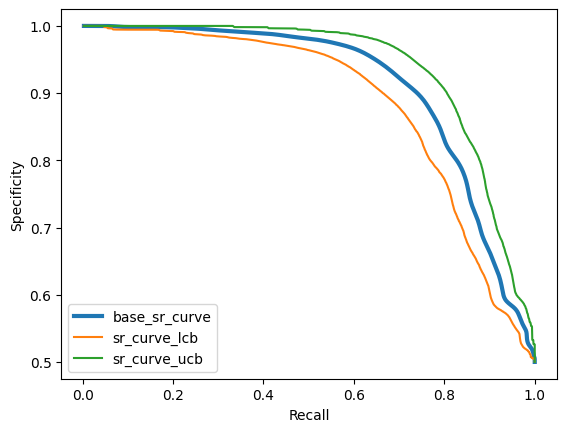

In [30]:
# Визуализация полученных результатов

plt.xlabel('Recall')
plt.ylabel('Specificity')

plt.plot(recall, specificity, linewidth = 3, label = 'base_sr_curve')
plt.plot(recall_lcb, specificity_lcb, label = 'sr_curve_lcb')
plt.plot(recall_ucb, specificity_ucb, label = 'sr_curve_ucb')

plt.legend();